# Analyse de séries temporelles avec un CNN 1D pour la maintenance prédictive

**Projet M1 Deep Learning**

Auteur : Massimo Venuti

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.lib.stride_tricks import sliding_window_view
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

## Exploration des données

In [2]:
df = pd.read_csv('oil_wells_data.csv')
df.head()

,timestamp,P-PDG,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,P-JUS-CKGL,T-JUS-CKGL,QGL,class
0,2018-05-17 22:56:06.000000,27897490.0,19824230.0,125.6859,4059666.0,97.55283,NaN,NaN,NaN,0
1,2018-05-17 22:56:07.000000,27897450.0,19824230.0,125.6859,4059666.0,97.55283,NaN,NaN,NaN,0
2,2018-05-17 22:56:08.000000,27897360.0,19824230.0,125.6859,4059666.0,97.55283,NaN,NaN,NaN,0
3,2018-05-17 22:56:09.000000,27897430.0,19824230.0,125.6859,4059666.0,97.55282,NaN,NaN,NaN,0
4,2018-05-17 22:56:10.000000,27897500.0,19824230.0,125.6859,4059666.0,97.55282,NaN,NaN,NaN,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26999 entries, 0 to 26998
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   timestamp   26999 non-null  object 
 1   P-PDG       26999 non-null  float64
 2   P-TPT       26999 non-null  float64
 3   T-TPT       26999 non-null  float64
 4   P-MON-CKP   26999 non-null  float64
 5   T-JUS-CKP   26999 non-null  float64
 6   P-JUS-CKGL  0 non-null      float64
 7   T-JUS-CKGL  0 non-null      float64
 8   QGL         0 non-null      float64
 9   class       26999 non-null  int64  
dtypes: float64(8), int64(1), object(1)
memory usage: 2.1+ MB


Les colonnes `P-JUS-CKGL`, `T-JUS-CKGL` et `QGL` sont totalement vides, on peut donc les supprimer. La colonne `timestamp` ne nous sera pas utile non plus, on la supprime également.

In [4]:
# Drop useless columns
df = df.dropna(axis=1)
df = df.drop('timestamp', axis=1)
df.head()

,P-PDG,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,class
0,27897490.0,19824230.0,125.6859,4059666.0,97.55283,0
1,27897450.0,19824230.0,125.6859,4059666.0,97.55283,0
2,27897360.0,19824230.0,125.6859,4059666.0,97.55283,0
3,27897430.0,19824230.0,125.6859,4059666.0,97.55282,0
4,27897500.0,19824230.0,125.6859,4059666.0,97.55282,0


In [5]:
df.iloc[:,:-1].describe()

,P-PDG,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP
count,2.699900e+04,2.699900e+04,26999.000000,2.699900e+04,26999.000000
mean,3.295801e+07,2.697894e+07,21.259920,4.011367e+06,50.281856
std,1.889676e+06,2.687977e+06,41.873765,1.972174e+04,24.776921
min,2.789731e+07,1.982423e+07,3.123855,4.001760e+06,27.831990
25%,3.365576e+07,2.770994e+07,3.414310,4.002244e+06,32.453840
50%,3.370013e+07,2.810358e+07,3.419258,4.002576e+06,36.627450
75%,3.370057e+07,2.816458e+07,3.548011,4.002728e+06,63.980940
max,3.374394e+07,2.820895e+07,126.163900,4.059666e+06,97.552830


Les différents attributs ont des ordres de grandeur clairement différents. Il faudra prendre soin de les standardiser lors de la création des jeux de tests et d'apprentissage.

In [3]:
df['class'].value_counts()

Les données sont très déséquilibrées, on a beaucoup d'instances correspondant à un incident comparé à celles correspondant à un état normal. Il faudra faire attention à cette disparité pour l'apprentissage.

Observons à présent l'évolution des différents attributs au cours du temps.

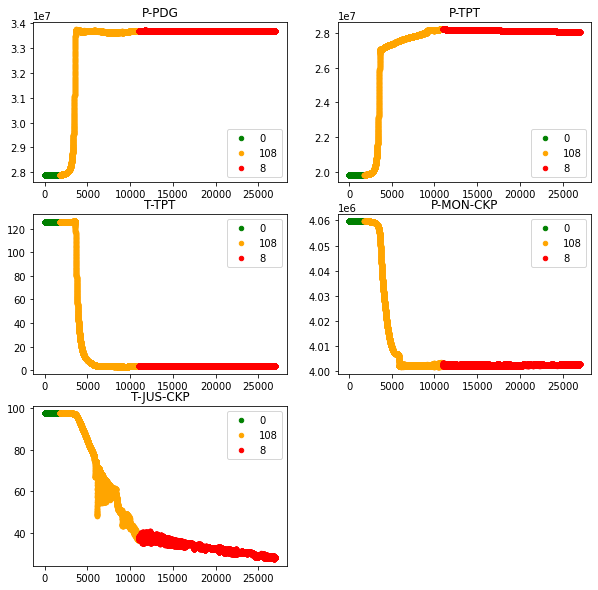

In [7]:
plt.figure(figsize=(10,10))

classes = [0, 108, 8]
colors = ['green', 'orange', 'red']

for i in range(5):
    ax = plt.subplot(3, 2, i+1)
    for j in range(3):
        tmp = df[df['class'] == classes[j]]
        ax.scatter(x=tmp.index, y=tmp[tmp.columns[i]], s=20, c=colors[j], label=classes[j])
    ax.set_title(df.columns[i])
    ax.legend()

plt.show()

Nous pouvons observer une nette évolution des attributs au cours du temps. Les attributs ont des valeurs bien distinctes entre les cas normaux et anormaux.

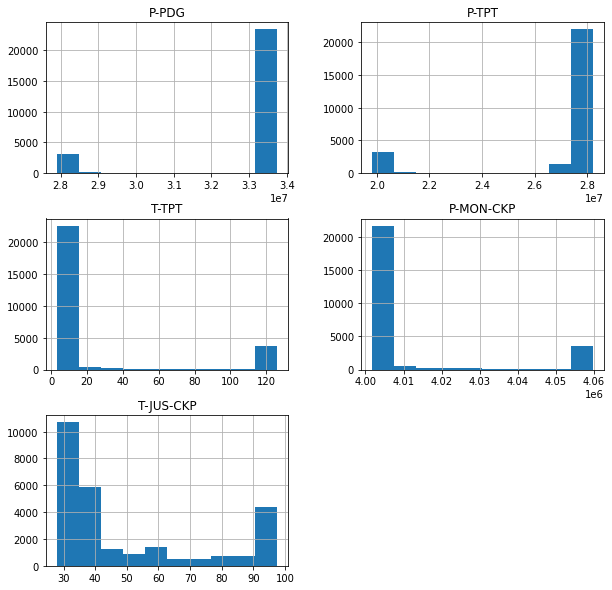

In [8]:
df.iloc[:,:-1].hist(figsize=(10,10))
plt.show()


On voit apparaître deux groupes dans la distribution des valeurs des attributs, indiquant certainement une distinction claire entre les cas normaux et anormaux.

L'apprentissage sera d'autant plus facile que les valeurs sont distinctes entre les cas normaux et anormaux.

## Transformation des données

Réalisons la transormation des données pour les rendre utilisables avec un CNN. Nous appliquons simplement une fenêtre glissante comme annoncé dans la première partie du projet. Nous commençons de manière arbitraire avec une taille de fenêtre de 32.

In [9]:
def sliding_window(df, window_size):
    # sequences
    sequences = sliding_window_view(df.iloc[:,:-1], (window_size,5), axis=(0,1))
    sequences = sequences.reshape(sequences.shape[:1] + sequences.shape[2:])

    # labels
    labels_sequences = sliding_window_view(df.iloc[:,-1], window_size)
    labels = np.array([2 if 8 in seq else 1 if 108 in seq else 0 for seq in labels_sequences])
    
    return sequences, labels 

In [10]:
window_size = 32
sequences, labels = sliding_window(df, window_size)

## Données déséquilibrées

Nous avons remarqué que les données sont très déséquilibrées. Après l'application de la fenêtre glissante, le déséquilibre est toujours fortement présent.

In [11]:
# Imbalance data
unique, counts = np.unique(labels, return_counts=True)
print(np.asarray((unique, counts)).T)

[[    0  1769]
 [    1  9200]
 [    2 15999]]


Une solution est donc de procéder à une méthode de resampling. Deux possibilités s'offrent alors à nous : le downsampling ou le upsampling. Dans le premier cas, on supprime aléatoirement des données de la classe majoritaire. Dans le deuxième cas, on copie aléatoirement des données de la classe minoritaire. Enfin, une troisième possibilité : faire du resampling en fonction de la classe médiane. Dans ce dernier cas, on réalise à la fois un downsampling sur la classe majoritaire et un upsampling sur la classe minoritaire, de manière à se rapprocher du nombre d'instances de la classe médiane.

Une méthode plus complexe consisterait à utiliser des GANs pour générer de nouvelles données.

In [9]:
# resampling
def data_resampling(sequences, labels, sorted_ref=0):
    classes = [sequences[labels == x] for x in [0, 1, 2]]
    lengths = [len(c) for c in classes]

    ref_length = sorted(lengths)[sorted_ref]

    for k in range(3):
        if lengths[k] < ref_length:
            # oversample
            classes[k] = resample(classes[k],
                                  replace=True,  # sample with replacement
                                  n_samples=ref_length,  # to match majority class
                                  random_state=123)
        elif lengths[k] > ref_length:
            #downsample
            classes[k] = resample(classes[k],
                                  replace=False,  # sample without replacement
                                  n_samples=ref_length,  # to match minority class
                                  random_state=123)

    new_sequences = np.concatenate(classes)
    new_labels = np.concatenate([np.full(len(classes[k]), k, dtype=np.int64) for k in [0, 1, 2]])

    return new_sequences, new_labels


def downsample(sequences, labels):
    return data_resampling(sequences, labels, 0)


def medsample(sequences, labels):
    return data_resampling(sequences, labels, 1)


def oversample(sequences, labels):
    return data_resampling(sequences, labels, 2)

Réalisons dans un premier temps un downsampling en guise d'exemple.

In [37]:
sequences_downsampled, labels_downsampled = downsample(sequences, labels)

In [38]:
unique, counts = np.unique(labels_downsampled, return_counts=True)
print(np.asarray((unique, counts)).T)

[[   0 1769]
 [   1 1769]
 [   2 1769]]


## Création des jeux d'entrainement et de test

Crééons à présent les jeux d'entrainement et de test pour l'apprentissage. Puisque nous avons des données avec des ordres de grandeur très différents, nous réalisons une standardisation des données **après** avoir fait la séparation en jeu d'entrainement et de test

In [39]:
X_train, X_test, y_train, y_test = train_test_split(sequences_downsampled, labels_downsampled, test_size=0.20, random_state=123)

In [11]:
# standardisation
def standard(X_train, X_test):
    scaler = StandardScaler().fit(X_train)
    X_train_std = scaler.transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
    X_test_std = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
    return X_train_std, X_test_std

In [41]:
X_train_std, X_test_std = standard(X_train, X_test)

## Un premier modèle simple

Nous pouvons à présent nous attaquer à la création d'un premier modèle très simple. Il est constitué d'un unique bloc Conv+Pooling. Le classifieur en sortie est lui constitué d'une seule couche cachée. J'utilise également un régularisateur L2 et un dropout pour le classifieur. Les paramètres tels que le nombre et la taille des filtres, le taux de dropout et la taille du pooling sont fixés arbritrairement.

Suite au downsampling réalisé précédemment, nous nous retrouvons avec un nombre limité de données. C'est pourquoi j'utilise ici l'optimisation SGD pour optimiser le modèle. Dans l'idéal, il faudrait également utiliser un learning rate adaptatif mais ce modèle sert uniquement de premier jet très simple pour voir les résultats qu'on peut déjà obtenir. Nous procèderons aux optimisations plus tard.

In [12]:
def make_model(input_shape, optimizer=SGD()):
    model = Sequential([
        Input(shape=input_shape),
        Conv1D(filters=12, kernel_size=4, strides=1,
            padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling1D(2),
        Flatten(),
        Dense(16, activation='relu',
            kernel_regularizer=l2(0.001)),
        Dropout(rate=0.2),  # drop 20% of the units of the previous layer
        Dense(3, activation='softmax'),
    ])

    model.compile(
        optimizer=optimizer,
        loss=SparseCategoricalCrossentropy(),
        metrics=['accuracy']
    )

    return model

In [43]:
model = make_model(X_train_std[0].shape)

early_stopping_cb = EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(np.array(X_train_std), np.array(y_train), batch_size=len(X_train_std), callbacks= [early_stopping_cb], epochs=100, validation_split=0.2)

Epoch 1/100
1/1 [==============================] - 1s 803ms/step - loss: 2.6463 - accuracy: 0.0038 - val_loss: 1.1390 - val_accuracy: 0.3157
Epoch 2/100
1/1 [==============================] - 0s 85ms/step - loss: 1.1990 - accuracy: 0.3410 - val_loss: 1.0547 - val_accuracy: 0.6561
Epoch 3/100
1/1 [==============================] - 0s 69ms/step - loss: 1.0498 - accuracy: 0.5718 - val_loss: 1.0183 - val_accuracy: 0.6561
Epoch 4/100
1/1 [==============================] - 0s 69ms/step - loss: 0.9833 - accuracy: 0.5986 - val_loss: 0.9880 - val_accuracy: 0.6561
Epoch 5/100
1/1 [==============================] - 0s 82ms/step - loss: 0.9145 - accuracy: 0.6269 - val_loss: 0.9677 - val_accuracy: 0.6561
Epoch 6/100
1/1 [==============================] - 0s 80ms/step - loss: 0.8869 - accuracy: 0.6325 - val_loss: 0.9516 - val_accuracy: 0.6561
Epoch 7/100
1/1 [==============================] - 0s 83ms/step - loss: 0.8440 - accuracy: 0.6561 - val_loss: 0.9375 - val_accuracy: 0.6561
Epoch 8/100
1/1 [==

In [13]:
def plot_history(history):
    training_loss = history.history['loss']
    training_acc = history.history['accuracy']
    val_loss = history.history['val_loss']
    val_acc = history.history['val_accuracy']

    plt.figure(figsize=(10, 4))
    plt.subplot(121)
    plt.plot(training_loss, label="Train loss")
    plt.plot(val_loss, label="Validation loss")
    plt.legend()
    plt.subplot(122)
    plt.plot(training_acc, label="Train accuracy")
    plt.plot(val_acc, label="Validation accuracy")
    plt.legend()
    plt.show()

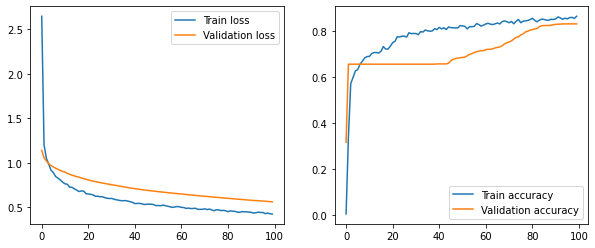

In [45]:
plot_history(history)

In [46]:
model.evaluate(X_test_std, y_test)

34/34 [==============================] - 0s 1ms/step - loss: 0.5549 - accuracy: 0.8362


[0.5548633933067322, 0.8361582159996033]

Les résultats semblent déjà très satisfaisants, sachant qu'aucune optimisation n'a encore été faite.

## Influence du resampling

Dans cette partie, nous essayons de mesurer l'impact du resampling sur les résultats de l'apprentissage. Pour ce faire nous comparerons les résultats obtenus avec les 3 méthodes de resampling présentées précédemment (downsampling, upsampling et resampling median).

Remarquons qu'il est possible d'ajouter un "ratio" au resampling. Par exemple, au lieu de faire un downsampling de la classe majoritaire pour atteindre exactement le nombre d'instances de la classe minoritaire, on pourrait faire en sorte d'atteindre au plus 150% du nombre d'instances de la classe minoritaire. Nous ne verrons pas cette méthode ici.

Pour l'évaluation de toutes les méthodes présentées dans ce notebook, j'utilise un **K-Fold** à 5 plis et l'accuracy comme mesure de performance.

In [14]:
def evaluate(inputs, labels, resample_fn, make_model_fn, repeat=1, make_model_fn_params=None):
    scores = []

    if make_model_fn_params is None:
        make_model_fn_params = {}

    kfold = KFold(n_splits=5, shuffle=True)
    for train, test in kfold.split(inputs, labels):
        X_train, y_train = resample_fn(sequences[train], labels[train]) 
        X_test, y_test = resample_fn(sequences[test], labels[test]) 
        X_train_std, X_test_std = standard(X_train, X_test)
        model = make_model_fn(X_train_std[0].shape, **make_model_fn_params)
        model.fit(X_train_std, y_train, epochs=30, verbose=0)
        score = model.evaluate(X_test_std, y_test, verbose=0)
        scores.append(score[1])
    return scores

In [15]:
def evaluate_resampling(inputs, labels, resample_fn):
    return evaluate(inputs, labels, resample_fn, make_model)

In [47]:
# downsampling
scores_downsampling = evaluate_resampling(sequences, labels, downsample)
print('# Downsampling')
print(f'Scores : {scores_downsampling}')
print(f'Mean score : {np.mean(scores_downsampling)}')

# Downsampling
Scores : [0.9472693204879761, 0.9538606405258179, 0.9472196102142334, 0.9453346133232117, 0.8765316009521484]
Mean score : 0.9340431571006775


In [48]:
# oversampling
scores_oversampling = evaluate_resampling(sequences, labels, oversample)
print('# Oversampling')
print(f'Scores : {scores_oversampling}')
print(f'Mean score : {np.mean(scores_oversampling)}')

# Oversampling
Scores : [0.9392322897911072, 0.9933983087539673, 0.9799010753631592, 0.6559571623802185, 0.945991575717926]
Mean score : 0.9028960824012756


In [64]:
# medsampling
scores_medsampling = evaluate_resampling(sequences, labels, medsample)
print('# Medsampling')
print(f'Scores : {scores_medsampling}')
print(f'Mean score : {np.mean(scores_medsampling)}')

# Medsampling
Scores : [0.9443544149398804, 0.943983793258667, 0.9612274765968323, 0.9294598698616028, 0.9473873972892761]
Mean score : 0.9452825903892517


Le resampling median semble donner les meilleurs résultats, c'est la méthode qu'on utilisera pour la suite. En utilisant cette méthode, on réussit à rassembler près de 30000 instances. C'est pourquoi il peut être intéressant d'utiliser les optimisations Adam ou RMSProp plutôt que SGD.

Voyons les résultats que l'on obtient avec l'une et l'autre optimisation.

## RMSprop vs Adam

Dans cette partie, on compare les résultats obtenus avec les optimisations RMSprop et Adam.

In [16]:
def evaluate_optimizer(inputs, labels, optimizer):
    return evaluate(inputs, labels, medsample, make_model, 1, {'optimizer':optimizer})

In [67]:
rms_prop_scores = evaluate_optimizer(sequences, labels, RMSprop(momentum=.9))
print("# RMSprop")
print(f"Scores : {rms_prop_scores}")
print(f"Mean score : {np.mean(rms_prop_scores)}")

adam_scores = evaluate_optimizer(sequences, labels, Adam())
print("Adam score")
print(f"Scores : {adam_scores}")
print(f"Mean score : {np.mean(adam_scores)}")

# RMSprop
Scores : [0.931009829044342, 0.9360413551330566, 0.9514001607894897, 0.9373838901519775, 0.9753424525260925]
Mean score : 0.9462355375289917
Adam score
Scores : [0.9780982732772827, 0.6518831253051758, 0.9627180695533752, 0.656620979309082, 0.9698996543884277]
Mean score : 0.8438440203666687


L'optimisation RMSprop semble donner les meilleurs résultats ici. Nous utiliserons donc cette optimisation par la suite.

## Influence de la taille de la fenêtre

Dans cette partie, nous essayons de mesurer l'influence de la taille de la fenêtre sur les résultats de l'apprentissage. Pour ce faire, nous comparons les résultats obtenus avec différentes tailles de fenêtres.

Par soucis de manque de puissance de calcul, je teste des tailles de fenêtre comprises entre 16 et 256.

In [17]:
def evaluate_window(inputs, labels):
    return evaluate(inputs, labels, medsample, make_model, 1, {'optimizer':RMSprop(momentum=.9)})

In [6]:
window_size_list = [16, 32, 64, 128, 256]
scores = []

for window_size in window_size_list:
    print(window_size)
    sequences, labels = sliding_window(df, window_size)
    scores_tmp = evaluate_window(sequences, labels)
    scores.append(np.mean(scores_tmp))
    print(scores[-1])

print(f"Scores : {scores}")

Scores : [0.9495804071426391, 0.9475802421569824, 0.8984230995178223, 0.9486016392707824, 0.8930267930030823]


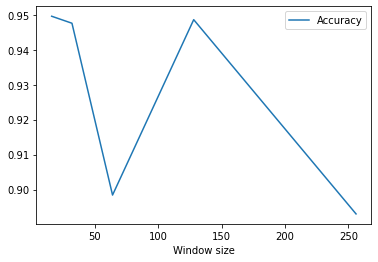

In [7]:
plt.plot(window_size_list, scores, label='Accuracy')
plt.xlabel('Window size')
plt.legend()
plt.show()

La taille de fenêtre glissante qui semble donner les meilleurs résultats est 16. Le temps de calcul se voit en plus réduit avec une petite taille de fenêtre comme celle-ci. Nous garderons donc cette valeur pour la suite.

In [18]:
window_size = 16
sequences, labels = sliding_window(df, window_size)

## Quelques architectures plus complexes

Essayons à présent des architectures plus complexes. Les hyperparamètres de ces modèles sont à nouveau fixés arbitrairement. Nous essayons de voir l'impact que peut avoir la "forme" et la complexité du modèle. Toutefois puisque le modèle utilisé initialement est très simple et donne déjà de bons résultats, je ne m'aventure pas vers des modèles trop complexes. 

In [182]:
# Model 1 (default model) : 1 conv + pooling block
def make_model_1(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        Conv1D(filters=12, kernel_size=4, strides=1,
            padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling1D(2),
        Flatten(),
        Dense(16, activation='relu',
            kernel_regularizer=l2(0.001)),
        Dropout(rate=0.2),
        Dense(3, activation='softmax'),
    ])

    model.compile(
        optimizer=RMSprop(momentum=.9),
        loss=SparseCategoricalCrossentropy(),
        metrics=['accuracy']
    )

    return model

In [404]:
# Model 2 : 2 conv + pooling blocks
def make_model_2(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        Conv1D(filters=12, kernel_size=4, strides=1,
               padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling1D(2),
        Conv1D(filters=12, kernel_size=4, strides=1,
               padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling1D(2),
        Flatten(),
        Dense(16, activation='relu',
              kernel_regularizer=l2(0.001)),
        Dropout(rate=0.2),
        Dense(3, activation='softmax'),
    ])
    model.compile(
        optimizer=RMSprop(momentum=.9),
        loss=SparseCategoricalCrossentropy(),
        metrics=['accuracy']
    )
    return model

In [258]:
# Model 3 : 2 conv blocks, no pooling
def make_model_3(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        Conv1D(filters=12, kernel_size=4, strides=1,
            padding='same', activation='relu'),
        BatchNormalization(),
        Conv1D(filters=12, kernel_size=4, strides=1,
        padding='same', activation='relu'),
        BatchNormalization(),
        Flatten(),
        Dense(16, activation='relu',
            kernel_regularizer=l2(0.001)),
        Dropout(rate=0.2),
        Dense(3, activation='softmax'),
    ])
    model.compile(
        optimizer=RMSprop(momentum=.9),
        loss=SparseCategoricalCrossentropy(),
        metrics=['accuracy']
    )
    return model

In [22]:
# Model 4 : 2 conv blocks + 1 pooling
def make_model_4(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        Conv1D(filters=12, kernel_size=4, strides=1,
            padding='same', activation='relu'),
        BatchNormalization(),
        Conv1D(filters=12, kernel_size=4, strides=1,
        padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling1D(2),
        Flatten(),
        Dense(16, activation='relu',
            kernel_regularizer=l2(0.001)),
        Dropout(rate=0.2),
        Dense(3, activation='softmax'),
    ])
    model.compile(
        optimizer=RMSprop(momentum=.9),
        loss=SparseCategoricalCrossentropy(),
        metrics=['accuracy']
    )
    return model

In [23]:
def evaluate_model(inputs, labels, make_model_fn):
    return evaluate(inputs, labels, medsample, make_model_fn)

In [24]:
make_model_fn_list = [make_model_1, make_model_2, make_model_3, make_model_4]
scores = []

for make_model_fn in make_model_fn_list:
    scores_tmp = evaluate_model(sequences, labels, make_model_fn)
    scores.append(np.mean(scores_tmp))

print(f"Scores : {scores}")

Scores : [0.9399391651153565, 0.9359598994255066, 0.7658207535743713, 0.9306130290031434]


Les deux modèles qui semblent donner les meilleurs résultats sont les modèles 1 et 2. Augmenter la complexité du modèle ne semble pas être d'une grande utilisé car le modèle initial (avec un unique bloc conv+pooling) semble donner des résultats similaires à ceux du deuxième modèle plus complexe. On remarque aussi qu'intégrer une couche de pooling après chaque couche de convolution semble fournir de meilleurs résultats.

## Optimisation bayésienne des paramètres

Voici des hyperparamètres du modèle sur lesquels on peut influer :

* Nombre de filtres
* Taille des filtres
* Stride
* Max pooling
* Nombre de neurones du classifieur
* Type de regularizer
* Weight decay
* Dropout rate
* Learning rate

L'idéal aurait été de les optimiser, avec une optimisation bayésienne par exemple. La librairie `scikit-optimize` est très bien pour mener à bien cette tâche.

Par soucis de temps, je ne fais pas cette optimisation et utilise les paramètres arbitraires choisis initialement qui donnent de bons résultats.

## Évaluation des deux meilleurs modèles

In [391]:
def test_model(inputs, labels, make_model_fn):
    X_train, X_test, y_train, y_test = train_test_split(inputs, labels, test_size=0.2)

    X_train, y_train = medsample(X_train, y_train)
    X_test, y_test = medsample(X_test, y_test)

    X_train_std, X_test_std = standard(X_train, X_test)

    model = make_model_fn(X_train_std[0].shape)

    early_stopping_cb = EarlyStopping(patience=5, restore_best_weights=True)
    history = model.fit(X_train_std, y_train, epochs=1000, validation_split=0.2, callbacks=[early_stopping_cb])

    y_pred = model.predict(X_test_std).argmax(axis=-1)

    class_report = classification_report(y_test, y_pred)
    cf_matrix = confusion_matrix(y_test, y_pred)

    return history, class_report, cf_matrix

### Modèle 1

In [409]:
# Test of model 1
history_1, class_report_1, cf_matrix_1 = test_model(sequences, labels, make_model_1)

Epoch 1/1000
551/551 [==============================] - 2s 3ms/step - loss: 0.2991 - accuracy: 0.8980 - val_loss: 1.1567 - val_accuracy: 0.5521
Epoch 2/1000
551/551 [==============================] - 1s 2ms/step - loss: 0.2462 - accuracy: 0.9169 - val_loss: 0.0229 - val_accuracy: 0.9945
Epoch 3/1000
551/551 [==============================] - 1s 2ms/step - loss: 0.2473 - accuracy: 0.9197 - val_loss: 0.0797 - val_accuracy: 0.9725
Epoch 4/1000
551/551 [==============================] - 1s 2ms/step - loss: 0.2311 - accuracy: 0.9229 - val_loss: 0.0316 - val_accuracy: 0.9896
Epoch 5/1000
551/551 [==============================] - 1s 2ms/step - loss: 0.2052 - accuracy: 0.9321 - val_loss: 0.0467 - val_accuracy: 1.0000
Epoch 6/1000
551/551 [==============================] - 1s 2ms/step - loss: 0.2312 - accuracy: 0.9240 - val_loss: 0.0355 - val_accuracy: 0.9968
Epoch 7/1000
551/551 [==============================] - 1s 2ms/step - loss: 0.2024 - accuracy: 0.9346 - val_loss: 0.0425 - val_accuracy:

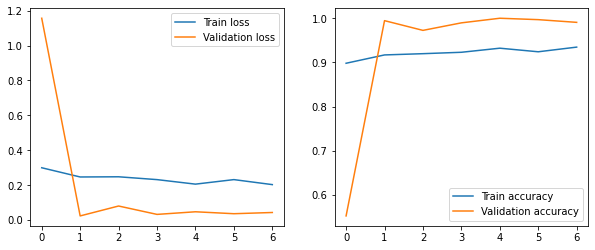

In [410]:
plot_history(history_1)

In [411]:
print("# Model 1 : classification report")
print(class_report_1)

# Model 1 : classification report
              precision    recall  f1-score   support

           0       0.88      1.00      0.94      1862
           1       0.99      0.83      0.90      1862
           2       0.96      0.99      0.98      1862

    accuracy                           0.94      5586
   macro avg       0.95      0.94      0.94      5586
weighted avg       0.95      0.94      0.94      5586



In [412]:
print("# Model 1 : confusion matrix")
print(cf_matrix_1)

# Model 1 : confusion matrix
[[1862    0    0]
 [ 248 1543   71]
 [   0   10 1852]]


Tout d'abord, nous pouvons constater un très bon résultat général, avec des scores au dessus de 0.8 pour toutes les métriques. L'accuracy atteint 0.94 sur cet essai, ce qui montre un bon résultat de classification général. Pour ce qui est de la classification en détail, on constate que toutes les instances de la classe 0 (état normal) on été prédites comme telles. En revanche, c'est celle qui a été le plus confondu avec la classe 1 (état transitif). Cela explique son score de précision qui est le plus mauvais des trois. En effet, 248 instances ont été prédites comme appartenant à la classe 0 alors qu'elles appartenaient en fait à la classe 1. On peut imaginer qu'il s'agit des premières instances de la classe transitive, où les variations des attributs sont encore faibles. Dans une moindre mesure, la classe 2 (état anormal) a également été confondu avec la classe 1 : 71 instances ont été prédites comme appartenant à la classe 2 alors qu'elles appartenaient en fait à la classe 1. Et 10 instances ont été prédites comme appartenant à la classe 1 alors qu'elles appartenaient en fait à la classe 2. On peut de manière analogue imaginer qu'il s'agit des dernières instances de la classe transitive. En somme, la classe 1 a été la plus difficile à prédire comme telle, comme l'indique le score de recall de 0.83. Cela semble logique étant donné qu'elle représente un état de transition. Les classes 0 et 2 ont en revanche été très bien prédites comme telles, avec des scores de recall quasi-parfaits.

Les résultats sont donc très satisfaisants, et on pouvait s'y attendre puisque les données ne semblaient initialement pas difficiles à départager. 

### Modèle 2

In [396]:
# Test of model 2
history_2, class_report_2, cf_matrix_2 = test_model(sequences, labels, make_model_2)

Epoch 1/1000
551/551 [==============================] - 2s 3ms/step - loss: 0.2863 - accuracy: 0.9049 - val_loss: 3.3154 - val_accuracy: 0.5403
Epoch 2/1000
551/551 [==============================] - 1s 2ms/step - loss: 0.2682 - accuracy: 0.9102 - val_loss: 0.0216 - val_accuracy: 1.0000
Epoch 3/1000
551/551 [==============================] - 1s 3ms/step - loss: 0.2578 - accuracy: 0.9111 - val_loss: 0.0552 - val_accuracy: 0.9989
Epoch 4/1000
551/551 [==============================] - 1s 2ms/step - loss: 0.2494 - accuracy: 0.9145 - val_loss: 0.1013 - val_accuracy: 0.9603
Epoch 5/1000
551/551 [==============================] - 1s 2ms/step - loss: 0.2484 - accuracy: 0.9156 - val_loss: 0.0744 - val_accuracy: 0.9741
Epoch 6/1000
551/551 [==============================] - 1s 2ms/step - loss: 0.2302 - accuracy: 0.9208 - val_loss: 0.0977 - val_accuracy: 0.9648
Epoch 7/1000
551/551 [==============================] - 1s 2ms/step - loss: 0.2560 - accuracy: 0.9153 - val_loss: 0.3659 - val_accuracy:

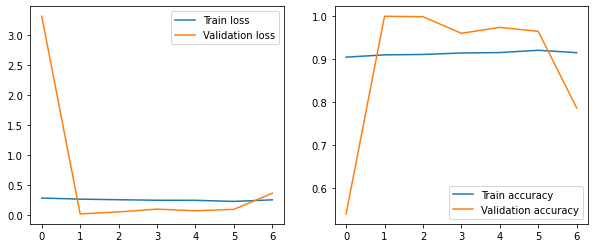

In [397]:
plot_history(history_2)

In [398]:
print("# Model 2 : classification report")
print(class_report_2)

# Model 2 : classification report
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      1853
           1       1.00      0.85      0.92      1853
           2       0.93      1.00      0.97      1853

    accuracy                           0.95      5559
   macro avg       0.95      0.95      0.95      5559
weighted avg       0.95      0.95      0.95      5559



In [399]:
print("# Model 2 : confusion matrix")
print(cf_matrix_2)

# Model 2 : confusion matrix
[[1853    0    0]
 [ 140 1580  133]
 [   0    0 1853]]


L'analyse est globalement la même que pour le modèle précédent. Les résultats sont très similaires et restent donc très bons. La classe 1 reste la moins bien prédite mais on note cette fois-ci une symétrie plus nette pour sa confusion avec la classe 0 et la classe 2. En effet, il y a quasiment autant d'instances qui ont été prédite à tord comme appartenant à la classe 0 et la classe 2 au lieu de la classe 1. 

## Discussions

Comme énoncé dans l'évalutation des deux meilleurs modèles, les résultats sont très bons mais sont à relativiser avec le fait que le problème initial ne semblait pas très difficile.

Après lecture de l'article [Understanding a Classification Report For Your Machine Learning Model](https://medium.com/@kohlishivam5522/understanding-a-classification-report-for-your-machine-learning-model-88815e2ce397#:~:text=The%20classification%20report%20visualizer%20displays,was%20positive%20and%20predicted%20positive), je réalise que j'aurai peut être dû préférer le f1-score à l'accuracy pour l'évaluation des différentes méthodes et modèles car il prend en compte la précision et le rappel. 